# ДЗ по "Сбор и разметка данных (семинары)"
## Семинар 9. Инструменты разметки наборов данных
* Домашнее задание:
- Задача 1.
Выберите датасет, который имеет отношение к вашей области интересов или исследований. Датасет должен содержать неструктурированные данные, требующие разметки для решения конкретной задачи, например, анализа настроений или распознавания именованных сущностей.

- Задача 2.
Выполните разметку на основе правил (rule-based labeling) на подмножестве выбранного датасета. Разработайте и реализуйте набор правил или условий, которые позволят автоматически присваивать метки данным на основе определенных шаблонов или критериев.

- Задача 3.
Выполните разметку вручную отдельного подмножества выбранного датасета с помощью выбранного вами инструмента разметки.

- Задача 4.
Объедините данные, размеченные вручную, с данными, размеченными на основе правил. Объедините два подмножества размеченных данных в один набор данных, сохранив при этом соответствующую структуру и целостность.

- Задача 5.
Обучите модель машинного обучения, используя объединенный набор размеченных данных. Разделите датасет на обучающий и тестовый наборы и используйте обучающий набор для обучения модели.

- Задача 6.
Оценить эффективность обученной модели на тестовом датасете. Используйте подходящие метрики оценки. Интерпретируйте результаты и проанализируйте эффективность модели в решении задачи разметки.



In [1]:
# Устанавливаем пакеты, если они не установлены
# !pip install pandas
# !pip install nltk
# !pip install scikit-learn
# !pip install label-studio
# !pip install matplotlib
# !pip install wget

In [2]:
import pandas as pd
import nltk
# Загружаем предобученную модель токенизации текста
nltk.download('punkt')
import csv
import os
import wget
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import matplotlib
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.metrics import f1_score

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\uc201\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Загрузка датасетов

###  Загрузка датасета новостей lenta.ru

In [3]:
# Загрузим датасет с новостями с lenta.ru
news = pd.read_csv('./csv/news_lenta_ru.csv', engine='python', on_bad_lines='skip')

In [4]:
news

,url,title,text,topic,tags
0,https://lenta.ru/news/1914/09/16/hungarnn/,1914. Русские войска вступили в пределы Венгрии,Бои у Сопоцкина и Друскеник закончились отступ...,Библиотека,Первая мировая
1,https://lenta.ru/news/1914/09/16/lermontov/,1914. Празднование столетия М.Ю. Лермонтова от...,"Министерство народного просвещения, в виду про...",Библиотека,Первая мировая
2,https://lenta.ru/news/1914/09/17/nesteroff/,1914. Das ist Nesteroff!,"Штабс-капитан П. Н. Нестеров на днях, увидев в...",Библиотека,Первая мировая
3,https://lenta.ru/news/1914/09/17/bulldogn/,1914. Бульдог-гонец под Льежем,Фотограф-корреспондент Daily Mirror рассказыва...,Библиотека,Первая мировая
4,https://lenta.ru/news/1914/09/18/zver/,1914. Под Люблином пойман швабский зверь,"Лица, приехавшие в Варшаву из Люблина, передаю...",Библиотека,Первая мировая
...,...,...,...,...,...
9995,https://lenta.ru/news/2000/07/10/kpp/,На границе Дагестана и Чечни будут стрелять в ...,Глава МВД Дагестана приказал нарядам милиции н...,Россия,Все
9996,https://lenta.ru/news/2000/07/10/gossovet/,Путин пересадит губернаторов в Госсовет,Представители Кремля ведут активный диалог с г...,Россия,Все
9997,https://lenta.ru/news/2000/07/10/clowns/,В Москву съедутся клоуны со всего мира,"В Москве 20 июля открывается фестиваль ""Планет...",Россия,Все
9998,https://lenta.ru/news/2000/07/10/women/,Старшая Уильямс выигрывает чемпионский титул,Чисто американским получился финал Уимблдонск...,Спорт,Все


### Загрузка тонального словаря

In [5]:
# Датасет тонального словаря
url = 'https://raw.githubusercontent.com/dkulagin/kartaslov/master/dataset/kartaslovsent/kartaslovsent.csv'
path = './csv/kartaslovsent.csv'
if not os.path.isfile("./csv/kartaslovsent.csv"):
    # Загружаем данные
    wget.download(url, out=path)

In [6]:
df_tone_dictionary = pd.read_csv('./csv/kartaslovsent.csv', sep=';', on_bad_lines='skip')

In [7]:
df_tone_dictionary

,term,tag,value,pstv,ngtv,neut,dunno,pstvNgtvDisagreementRatio
0,абажур,NEUT,0.08,0.185,0.037,0.580,0.198,0.00
1,аббатство,NEUT,0.10,0.192,0.038,0.578,0.192,0.00
2,аббревиатура,NEUT,0.08,0.196,0.000,0.630,0.174,0.00
3,абзац,NEUT,0.00,0.137,0.000,0.706,0.157,0.00
4,абиссинец,NEUT,0.28,0.151,0.113,0.245,0.491,0.19
...,...,...,...,...,...,...,...,...
46122,ёмкость,NEUT,0.00,0.167,0.000,0.690,0.143,0.00
46123,ёрзать,NGTV,-0.54,0.050,0.446,0.397,0.107,0.00
46124,ёрничать,NGTV,-0.79,0.078,0.529,0.236,0.157,0.00
46125,ёрш,NEUT,0.16,0.224,0.072,0.576,0.128,0.00


## Присвоение метки настроения заголовкам новостей

### Перемешаем и разделим датафрейм на две части (1-разметка вручную, 2-разметка на основе правил)

In [8]:
# Перемешаем и разделим датафрем на 2 части
title_news_1, title_news_2 = train_test_split(news['title'], train_size=5, random_state=42)

In [9]:
# Преобразуем полученые датасеты в датафреймы Pandas
df_title_news_1 = pd.DataFrame(title_news_1)
df_title_news_2 = pd.DataFrame(title_news_2)

In [10]:
df_title_news_1.head()

,title
5734,Ястржембский называет имя арестованного за взр...
5191,"Чемпионат Италии: ""Ювентус"" ушел в отрыв"
5390,Из Чернокозово отпущены первые амнистированные...
860,Парламент Украины затребовал у Конгресса США п...
7270,Пилот Формулы-1 уцелел в авиакатастрофе


In [11]:
df_title_news_2.head()

,title
6252,"Чтобы не платить налог, интернет-изданиям нужн..."
4684,Кубинского дипломата выставили из США
1731,Правительство РФ: третье тысячеление наступит ...
4742,Взрывчатку в Сибирь отправили по почте
4521,В Дагестане совершено покушение на генерала по...


### Определение функций

In [12]:
# Функция для присвоения метки настроения на основе наличия положительных или отрицательных слов
def get_sentiment(text, df_td=df_tone_dictionary):
    '''
    Функция вычисляет метрику настроения.

    :param text: текст который будем анализировать,
    :param df_td: тональный словарь,
    :return: возвращает оценку тональности: -0.35 (неготив) <= нейтрально >= (0.55) позитив 
    '''
    # Токенизация текста на отдельные слова
    words = nltk.word_tokenize(text.lower())
    sum_value = 0  # Сумма всех зачений весов найденных слов
    
    for word in words:
        if len(df_td[df_td.term == word]):
            df_filtered = df_td[df_td['term'] == word]
            value = df_filtered['value'].iloc[0]
            sum_value += value
 
    return sum_value   


In [13]:
# Определение функции для присвоения метки настроения на основе оценки полярности настроения
def get_sentiment_label(score):
    '''
    Функция выводит метку настроения (негативный, позитивный или нейтральный).

    :param score: уровень метки настроения от -1 до 1,
    :return: возвращает оценку тональности. 
    '''
    if score < -0.35:
        return 'negative'  
    elif score >= 0.55:
        return 'positive' 
    else:
        return 'neutral'

#### Проверка функций

In [14]:
%%time
get_sentiment('Превосходно, что Аист прелетел')

CPU times: total: 0 ns
Wall time: 21 ms


0.55

In [15]:
get_sentiment('Удар молнии')

-0.68

In [16]:
get_sentiment('Всё в норме')

0

In [17]:
get_sentiment_label(get_sentiment('Превосходно, что Аист прелетел'))

'positive'

In [18]:
get_sentiment_label(get_sentiment('Удар молнии'))

'negative'

In [19]:
get_sentiment_label(get_sentiment('Всё в норме'))

'neutral'

### Присваиваем метки

#### Присвоение меток настроения на основе правил

In [20]:
%%time
# Применение функции к столбцу 'title' датасета для получения полярности настроения каждого заголовка новости
df_title_news_2['sentiment'] = df_title_news_2['title'].apply(get_sentiment)
# Применение функции к столбцу 'sentiment' датасета для присвоения меток настроения
df_title_news_2['sentiment_label'] = df_title_news_2['sentiment'].apply(get_sentiment_label)

CPU times: total: 1min 30s
Wall time: 2min 13s


In [21]:
df_title_news_2.head()

,title,sentiment,sentiment_label
6252,"Чтобы не платить налог, интернет-изданиям нужн...",-0.26,neutral
4684,Кубинского дипломата выставили из США,0.00,neutral
1731,Правительство РФ: третье тысячеление наступит ...,-0.14,neutral
4742,Взрывчатку в Сибирь отправили по почте,0.00,neutral
4521,В Дагестане совершено покушение на генерала по...,-1.00,negative


In [22]:
df_title_news_2.shape

(9995, 3)

#### Присвоение меток настроения в label-studio

##### Сохраним датафрем в CSV файл

In [23]:
df_title_news_1.to_csv('./csv/manual_marking.csv', index=False)

##### Запускаем локально label-studio

In [24]:
!label-studio

^C


##### Экспортируем размеченный вручную CSV файл и зогружаем его в датафрейм

In [54]:
df_title_news_1 = pd.read_csv('./csv/project-1-at-2024-04-14-20-19-3822a918.csv', engine='python', on_bad_lines='skip')

In [55]:
df_title_news_1.head()

,annotation_id,annotator,created_at,id,lead_time,sentiment,title,updated_at
0,1,1,2024-04-14T16:08:25.109948Z,1,18.735,positive,Ястржембский называет имя арестованного за взр...,2024-04-14T16:08:33.034497Z
1,2,1,2024-04-14T16:09:05.374325Z,2,13.131,neutral,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",2024-04-14T16:17:06.400265Z
2,3,1,2024-04-14T16:09:26.498394Z,3,6.770,negative,Из Чернокозово отпущены первые амнистированные...,2024-04-14T16:09:26.498394Z
3,4,1,2024-04-14T16:09:59.909605Z,4,7.341,neutral,Парламент Украины затребовал у Конгресса США п...,2024-04-14T16:09:59.909605Z
4,5,1,2024-04-14T16:10:25.863949Z,5,4.486,positive,Пилот Формулы-1 уцелел в авиакатастрофе,2024-04-14T16:10:25.863949Z


In [56]:
# Оставим только нужные столбцы
df_title_news_1 = df_title_news_1[['title', 'sentiment']].rename(columns={'sentiment': 'sentiment_label'})

In [57]:
df_title_news_1.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,positive
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",neutral
2,Из Чернокозово отпущены первые амнистированные...,negative
3,Парламент Украины затребовал у Конгресса США п...,neutral
4,Пилот Формулы-1 уцелел в авиакатастрофе,positive


## Объединение датафреймов

In [58]:
# Объеденим три датафрейма
df_title_news_concat = pd.concat([
    df_title_news_1,
    df_title_news_2,
], axis=0)
# Удалим лишний столбец
del df_title_news_concat['sentiment']

In [59]:
df_title_news_concat.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,positive
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",neutral
2,Из Чернокозово отпущены первые амнистированные...,negative
3,Парламент Украины затребовал у Конгресса США п...,neutral
4,Пилот Формулы-1 уцелел в авиакатастрофе,positive


In [60]:
df_title_news_concat.shape

(10000, 2)

<Axes: >

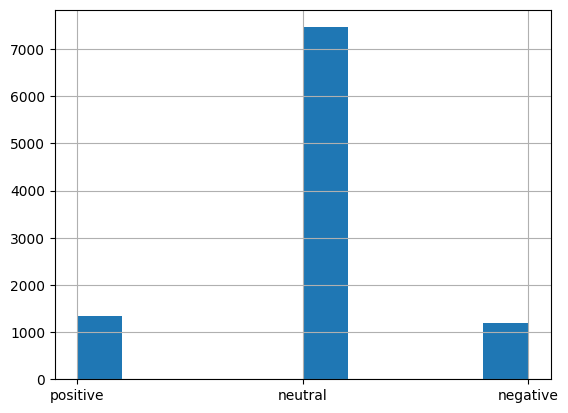

In [61]:
# Выведем график тональности заголовков новостей
df_title_news_concat['sentiment_label'].hist()

In [62]:
# Статистика тональности заголоаков новостей
df_title_news_concat.groupby(['sentiment_label']).agg({'sentiment_label': ['count']})

,sentiment_label
,count
sentiment_label,
negative,1186
neutral,7463
positive,1351


## Обучение модели

In [63]:
le = LabelEncoder()
# Преобразуем в датафрейме буквеное обозначение в цифровое
df_title_news_concat['sentiment_label'] = le.fit_transform(df_title_news_concat['sentiment_label'].astype(str))

In [64]:
df_title_news_concat.head()

,title,sentiment_label
0,Ястржембский называет имя арестованного за взр...,2
1,"Чемпионат Италии: ""Ювентус"" ушел в отрыв",1
2,Из Чернокозово отпущены первые амнистированные...,0
3,Парламент Украины затребовал у Конгресса США п...,1
4,Пилот Формулы-1 уцелел в авиакатастрофе,2


In [65]:
# Перемешивание данных
df_title_news_concat = shuffle(df_title_news_concat)

In [66]:
# Разделение датасета на размеченную и неразмеченную выборки
labeled_title, unlabeled_title = train_test_split(df_title_news_concat, train_size=0.2, random_state=42)

In [67]:
labeled_title.head()

,title,sentiment_label
7269,В Чечне погибли три инспектора ГИБДД,1
5797,Контактная группа по бывшей Югославии вновь за...,1
208,На выборах губернатора Свердловской области по...,1
9026,В США сошел с рельсов и загорелся товарный поезд,1
2881,"Боевики сообщили, что сбит российский вертолет",1


In [68]:
unlabeled_title.head()

,title,sentiment_label
6312,"Немецкие спецслужбы опровергают, что передавал...",1
6787,Водитель автокрана парализовал движение на Сад...,1
6305,Детдомовцы хранили гранаты и взрывчатку,1
9219,ОПЕК увеличивает добычу нефти,1
4387,Чеченцы пытались отбить своих у милиции,0


In [69]:
# Определение функции для обучения модели логистической регрессии на размеченных данных
def train_model(labeled_title):
    # Векторизация текстовых данных с помощью TF-IDF
    vectorizer = TfidfVectorizer()
    X = vectorizer.fit_transform(labeled_title['title'])
    y = labeled_title['sentiment_label']

    # Обучение модели логистической регрессии на размеченных данных
    model = LogisticRegression()
    model.fit(X, y)

    return model, vectorizer

In [70]:
# Обучение начальной модели на небольшом наборе 
model, vectorizer = train_model(labeled_title)

In [71]:
# Использование исходной модели для прогнозирования настроения неразмеченных данных
X_unlabeled = vectorizer.transform(unlabeled_title['title'])
y_unlabeled_predicted = model.predict(X_unlabeled)

In [72]:
# Вычислить неопределенности или энтропии предсказаний
y_unlabeled_proba = model.predict_proba(X_unlabeled)
uncertainty = -(y_unlabeled_proba * np.log2(y_unlabeled_proba)).sum(axis=1)

In [73]:
# Выбор 100 наиболее неопределенных точек данных для маркировки человеком
labeled_title_new = unlabeled_title.iloc[uncertainty.argsort()[:100]]
unlabeled_title_new = unlabeled_title.iloc[uncertainty.argsort()[100:]]

In [74]:
labeled_title_new

,title,sentiment_label
7169,В Красноярске подростка достали из вентиляцион...,1
5221,Жилой квартал Тегерана обстреляли из миномета,1
2078,Власти Сербии не пропускают топливо из EC,1
8278,Новый бесплатный сыр: онлайновый университет B...,2
1301,Новый Панамский канал проложат посуху,2
...,...,...
8556,В Чечне освобожден предприниматель из Ростова,1
3449,Один из убийц лидера сербских боевиков находит...,1
2331,Из питерской Академии художеств украли 16 картин,1
6980,Беженка из Таджикистана совершила попытку само...,0


In [75]:
# Разметка новых точек данных и добавление их к размеченному множеству
labeled_title = pd.concat([labeled_title, labeled_title_new])

In [76]:
labeled_title.shape

(2100, 2)

In [77]:
unlabeled_title_new.shape

(7900, 2)

In [78]:
# Переобучение модели на расширенном маркированном множестве
model, vectorizer = train_model(labeled_title)

## Оценка обучения модели

In [79]:
### Загружаем тестовый датасет
title_test = pd.read_csv('./csv/test.csv', engine='python', on_bad_lines='skip')

In [80]:
# Преобразуем в датафрейме буквеное обозначение в цифровое
title_test['sentiment_label'] = le.fit_transform(title_test['sentiment_label'].astype(str))

In [81]:
title_test.head()

,title,sentiment_label
0,Вагоны московского метро будут складываться га...,1
1,В Чечню пытались проникнуть наемники из Пакистана,1
2,Таллинские заключенные предпочитают голод духоте,0
3,"Адвокатам ""Моста"" не удалось дать отвод следов...",1
4,В поезде Донецк-Москва нашли взрывчатку,1


In [82]:
# Оценка модели на тестовом датасете
X_test = vectorizer.transform(title_test['title'])
y_test_predicted = model.predict(X_test)
f1 = f1_score(title_test['sentiment_label'], y_test_predicted, average='micro')

print(f1)

0.84008


## Вывод:

### Выполнил разметку выбранного подмножества на основе правил, произвел разметку вручную другого подмножества. Объединил эти две выборки в один дасет и произвел обучение модели. Эффективность обученной модели составила 84%. Разметка на основе правил существенно экономит трудозатраты.